In [ ]:
! pip install joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# 사원 퇴사 / 근속 데이터
-> 근무 중 인원, 퇴사 인원 파악

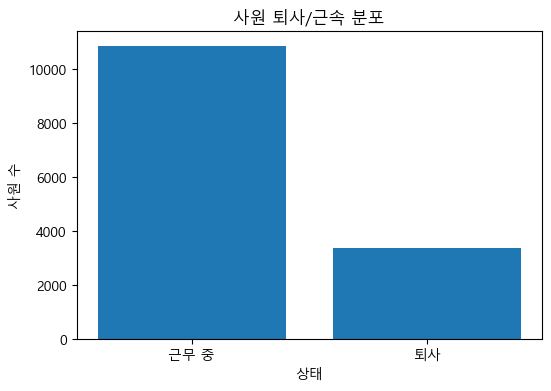

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import platform

# os 별 폰트 적용
if platform.system() == 'Darwin' :
    plt.rcParams["font.family"] = "AppleGothic"
else :
    plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
data = pd.read_csv('employee_churn.csv')

status = data['status'].value_counts()

plt.figure(figsize=(6, 4))

plt.bar(['근무 중', '퇴사'], status)
plt.title('사원 퇴사/근속 분포')
plt.xlabel('상태')
plt.ylabel('사원 수')
plt.show()

## 이상치 확인

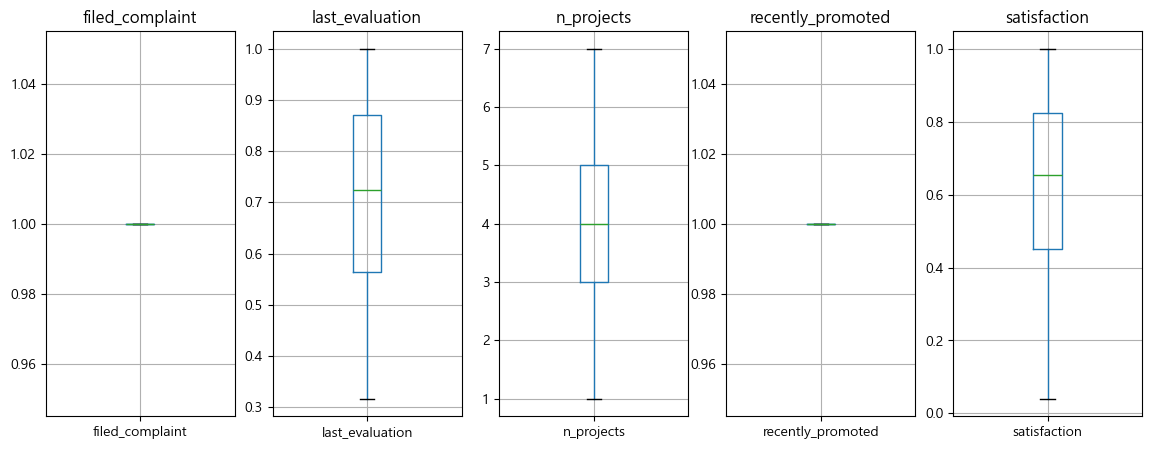

In [103]:
import matplotlib.pyplot as plt

# Boxplot을 이용해 이상치 확인
columns = ['filed_complaint', 'last_evaluation', 'n_projects', 'recently_promoted', 'satisfaction']

plt.figure(figsize=(20, 5))
for i, c in  enumerate(columns) :
    plt.subplot(1, 7, i+1)
    data[[c]].boxplot()
    plt.title(c)

plt.show()

## 결측치 확인

In [104]:
data.isna().sum()

avg_monthly_hrs          0
department             709
filed_complaint      12191
last_evaluation       1532
n_projects               0
recently_promoted    13949
salary                   0
satisfaction           181
status                   0
tenure                 181
dtype: int64

## 결측 값 처리

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

####################### 결측치 처리 ##########################

# 'department' 열의 결측치 삭제
if 'department' in data.columns:
    data = data.drop('department', axis=1)

# 'filed_complaint'과 'recently_promoted' 컬럼 데이터의 결측값을 0으로 채우기
data['filed_complaint'] = data['filed_complaint'].fillna(0)
data['recently_promoted'] = data['recently_promoted'].fillna(0)

# 'tenure'컬럼 데이터 근속 연수를 구하므로 결측값을 1으로 채우기
data['tenure'] = data['tenure'].fillna(1)

# 'last_evaluation', 'satisfaction' 결측치를 평균값으로 대체
data['last_evaluation'] = data['last_evaluation'].fillna(data['last_evaluation'].mean())
data['satisfaction'] = data['satisfaction'].fillna(data['satisfaction'].mean())

####################### 결측치 처리 끝 ##########################



#######################  Scaling 처리 #############################

# 수치형 데이터 Scaler
scaler = StandardScaler()
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# 범주형 변수를 Label Encoding으로 변환
categorical_columns = data.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # 각 열의 인코더 저장 (나중에 해석 가능)

#######################  Scaling 처리 끝 #############################



#######################  trainset / testset 분리  #############################

X = data.drop('status', axis=1)  # 이탈 여부 열을 제외한 데이터
y = data['status']  # 이탈 여부 열만 선택

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#######################  trainset / testset 분리 끝  #############################

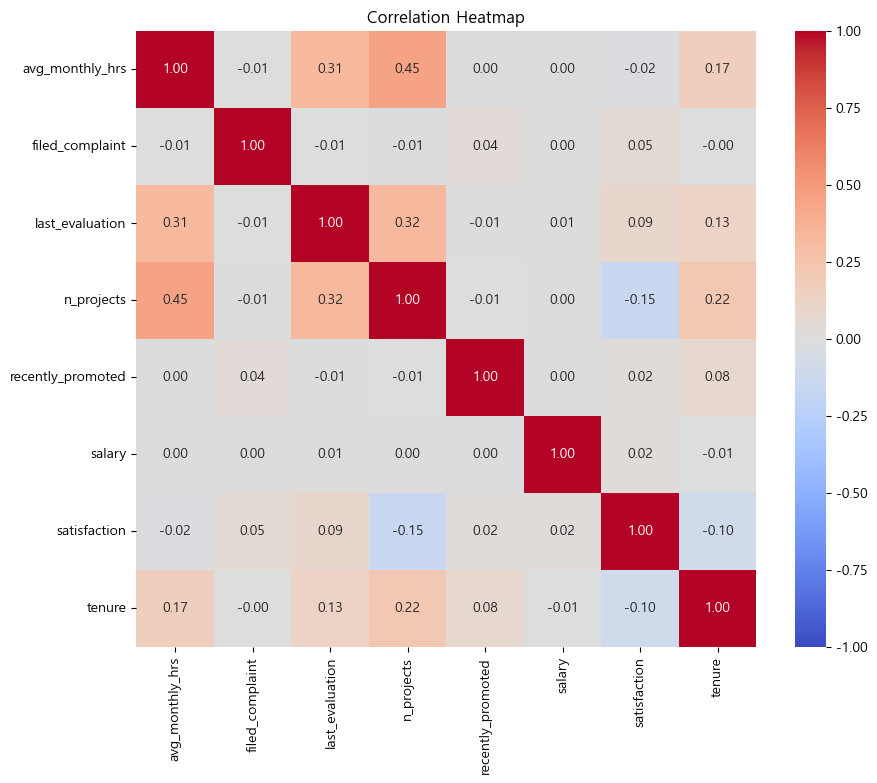

In [106]:
# 상관관계
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# 머신 러닝

#### 평가 함수 정의

In [107]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay

# 성능 평가 함수 정의
def evaluate_model(model, X_test, y_test, title=None):
    y_pred = model.predict(X_test)
    print(f'============= {title} 모델 평가 지표 =============')
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print(f'=====================================================')


# 최적 모델을 평가하는 함수
def evaluate_and_visualize_model(model, X_test, y_test, title=None):
    # 예측 수행
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # 혼동 행렬
    print("혼동 행렬 : ")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{title} 모델 혼동 행렬')
    plt.show()

    # ROC 곡선 및 AUC 점수
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = roc_auc_score(y_test, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print("ROC Curve를 사용 할 수 없는 모델입니다.")

    # 특성 중요도 (랜덤 포레스트, 그라디언트 부스팅 등 트리 기반 모델만 해당)
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        features = X_test.columns
        indices = importances.argsort()[::-1]  # 중요도 순서로 정렬

        plt.figure(figsize=(10, 6))
        plt.title("특성 중요도")
        plt.bar(range(len(indices)), importances[indices], align="center")
        plt.xticks(range(len(indices)), [features[i] for i in indices], rotation=90)
        plt.show()
    else:
        print("특성 중요도를 사용할 수 없는 모델입니다")


#### 과적합 검증 함수 정의

In [108]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 학습 곡선 시각화를 위한 함수
def plot_learning_curve_ensemble(model, X_train, y_train, X_test, y_test, param_range, title="Learning Curve") :
    train_scores = []
    val_scores = []
    
    # 각 트리 개수에 대해 훈련 및 검증 정확도를 기록
    for n_estimators in param_range:
        # 모델 학습
        model.set_params(n_estimators=n_estimators)
        model.fit(X_train, y_train)

        # 훈련 데이터 정확도
        y_train_pred = model.predict(X_train)
        train_score = accuracy_score(y_train, y_train_pred)
        train_scores.append(train_score)
        
        # 검증 데이터 정확도
        y_test_pred = model.predict(X_test)
        val_score = accuracy_score(y_test, y_test_pred)
        val_scores.append(val_score)
    
    # 학습 곡선 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_scores, label="Train Accuracy", marker='o', color='blue')
    plt.plot(param_range, val_scores, label="Validation Accuracy", marker='o', color='orange')
    plt.xlabel("Number of Trees (n_estimators)")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# 학습 곡선 시각화를 위한 함수
def plot_learning_curve_Decision(model, X_train, y_train, X_test, y_test, param_range, title="Learning Curve") :
    train_accuracies = []
    val_accuracies = []

    for depth in param_range:
        model.set_params(max_depth=depth, random_state=0)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_val_pred = model.predict(X_test)
        val_accuracies.append(accuracy_score(y_test, y_val_pred))

    
    # 학습 곡선 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(param_range, val_accuracies, label='Validation Accuracy', marker='o')
    plt.title(f'Learning Curve for {title}')
    plt.xlabel(f'Max Depth of {title}')
    plt.ylabel('Accuracy')
    plt.xticks(param_range)
    plt.title(title)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid()
    plt.show()


def plot_learning_curve_KNN(model, X_train, y_train, X_test, y_test, param_range, title="KNN Learning Curve") :
    train_scores = []
    val_scores = []

    # 각 k 값에 대해 훈련 및 검증 정확도를 기록
    for k in param_range:
        # 모델 학습
        model.set_params(n_neighbors=k)
        model.fit(X_train, y_train)

        # 훈련 데이터 정확도
        y_train_pred = model.predict(X_train)
        train_score = accuracy_score(y_train, y_train_pred)
        train_scores.append(train_score)

        # 검증 데이터 정확도
        y_test_pred = model.predict(X_test)
        val_score = accuracy_score(y_test, y_test_pred)
        val_scores.append(val_score)

    # 학습 곡선 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_scores, label="Train Accuracy", marker='o', color='blue')
    plt.plot(param_range, val_scores, label="Validation Accuracy", marker='o', color='orange')
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



## Random Forest

============= 랜덤 포레스트 모델 평가 지표 =============
Accuracy: 0.9824561403508771
Precision: 0.9780907668231612
Recall: 0.9455370650529501
F1 Score: 0.9615384615384616

최적의 하이퍼파라미터 :  {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20} 

============= 랜덤 포레스트 최적 하이퍼파라미터 모델 평가 지표 =============
Accuracy: 0.9810526315789474
Precision: 0.9809825673534073
Recall: 0.9364599092284418
F1 Score: 0.958204334365325
혼동 행렬 : 


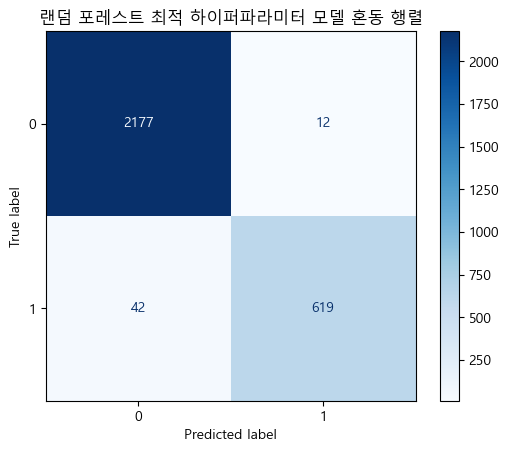

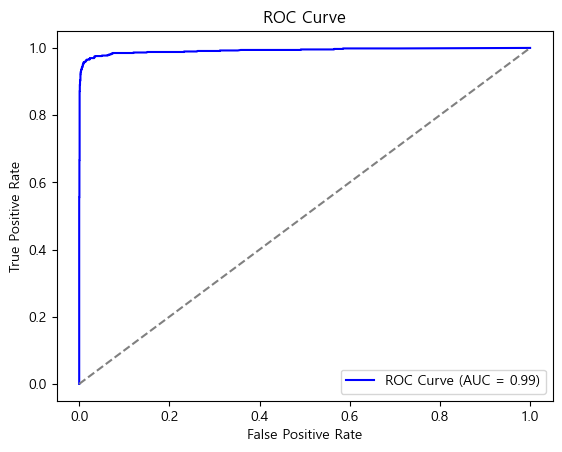

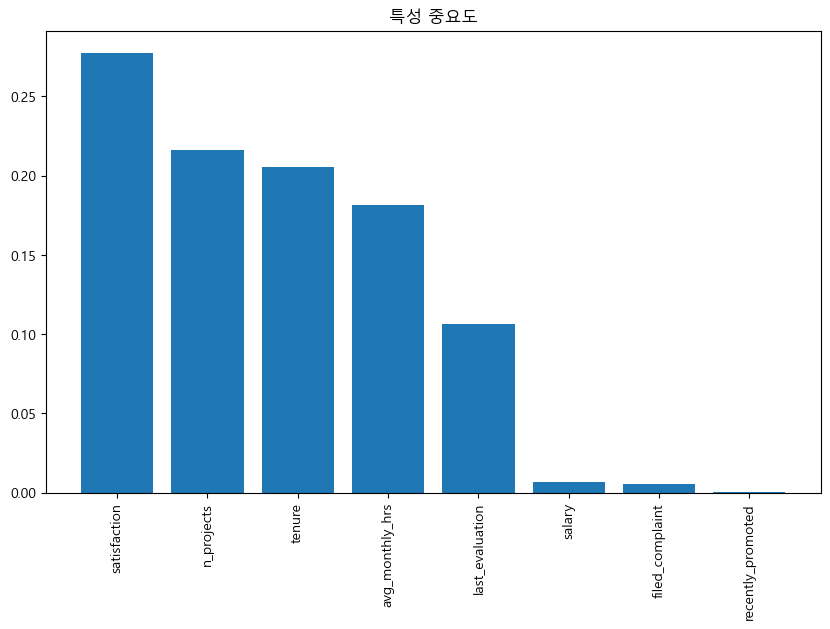

In [109]:
## 랜덤포레스트 모델

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(random_state=0)  # 모델 생성
rf.fit(X_train, y_train) # 모델 학습
evaluate_model(rf, X_test, y_test, '랜덤 포레스트') # 모델 평가

# 랜덤 포레스트 하이퍼파라미터 튜닝 (RandomizedSearchCV)
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수를 더 큰 값으로 하지 않음
    'max_depth': [10, 15, 20],       # 트리 깊이를 제한
    'min_samples_split': [5, 10, 15], # 노드 분할을 위한 최소 샘플 수를 높임
    'min_samples_leaf': [2, 4, 6],    # 리프 노드의 최소 샘플 수를 늘림
    'max_features': ['sqrt', 'log2']  # 트리의 최대 특성 비율 조정
}

# RandomizedSearchCV 활용
randomsearch = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=50, cv=3, n_jobs=-1, scoring='accuracy', random_state=0)
randomsearch.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 성능 출력
print("\n최적의 하이퍼파라미터 : ", randomsearch.best_params_,'\n')
rf_best = randomsearch.best_estimator_
best_params = randomsearch.best_params_
evaluate_model(rf_best, X_test, y_test, '랜덤 포레스트 최적 하이퍼파라미터')

# 최종 평가: 최적화된 모델을 평가하고 시각적으로 분석
evaluate_and_visualize_model(rf_best, X_test, y_test, '랜덤 포레스트 최적 하이퍼파라미터') 

## 과적합 검증

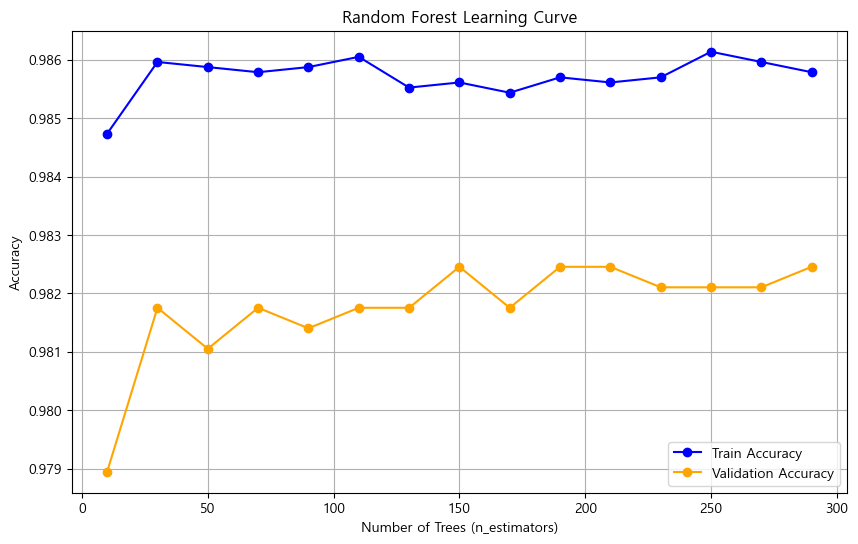

In [110]:

# 트리 개수의 범위 설정
param_range = range(10, 300, 20)  # 트리 개수를 10에서 300까지 20 단위로 증가

# 모델 및 학습 곡선 시각화 호출
rf = RandomForestClassifier(random_state=0, max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], min_samples_leaf=best_params['min_samples_leaf'], max_features=best_params['max_features'])
plot_learning_curve_ensemble(rf, X_train, y_train, X_test, y_test, param_range, title="Random Forest Learning Curve")

## 과적합 여부 확인 결과

### 1. 훈련 정확도와 검증 정확도의 유사성:
훈련 정확도와 검증 정확도 사이의 차이가 크게 벌어지지 않고 유사한 수준에서 유지되고 있습니다.<br>
이는 모델이 훈련 데이터에 과도하게 맞춰지지 않고, 검증 데이터에도 잘 일반화되고 있음을 의미합니다.<br>

### 2. 트리 개수 증가에 따른 안정적인 성능:
트리 개수를 늘려도 훈련 정확도와 검증 정확도 모두 큰 변화 없이 안정적인 수치를 유지하고 있습니다.<br>
이는 추가적인 학습으로 인해 모델이 과적합되지 않고 일정한 성능을 유지하고 있다는 것을 나타냅니다.<br>

### 3. 검증 정확도의 안정적 수렴:
검증 정확도가 특정 값(약 0.982) 근처에서 안정화되었으며, 훈련 정확도 역시 0.985 부근에서 일정하게 유지되고 있습니다.<br>
두 곡선이 비슷한 수준에서 수렴하는 모습은 모델이 일반화된 성능을 보이고 있음을 나타냅니다.<br>


따라서, 위 이유들로 판단했을 때 이 모델은 과적합되지 않았으며, 데이터에 대해 적절한 일반화 성능을 갖추고 있다고 할 수 있습니다.

## Decision Tree

============= DecisionTreeClassifier 모델 모델 평가 지표 =============
Accuracy: 0.9635087719298245
Precision: 0.9101620029455081
Recall: 0.9349470499243571
F1 Score: 0.9223880597014925

최적의 하이퍼파라미터 :  {'max_leaf_nodes': 29, 'max_features': np.float64(0.9), 'max_depth': 5} 

============= DecisionTree 최적 하이퍼파라미터 모델 평가 지표 =============
Accuracy: 0.9701754385964912
Precision: 0.95
Recall: 0.9198184568835098
F1 Score: 0.9346656418139893
혼동 행렬 : 


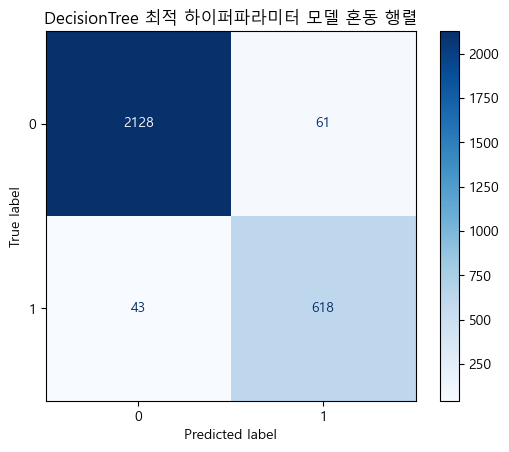

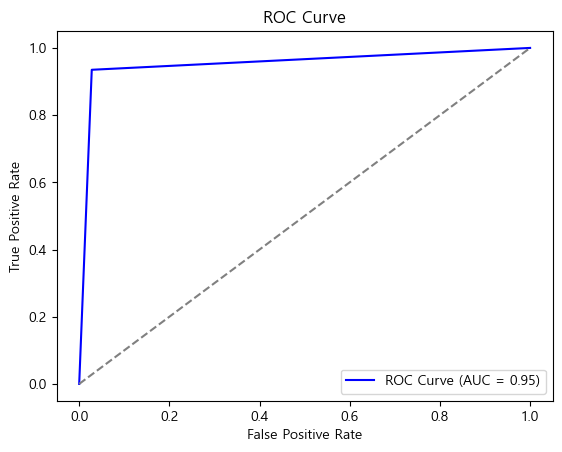

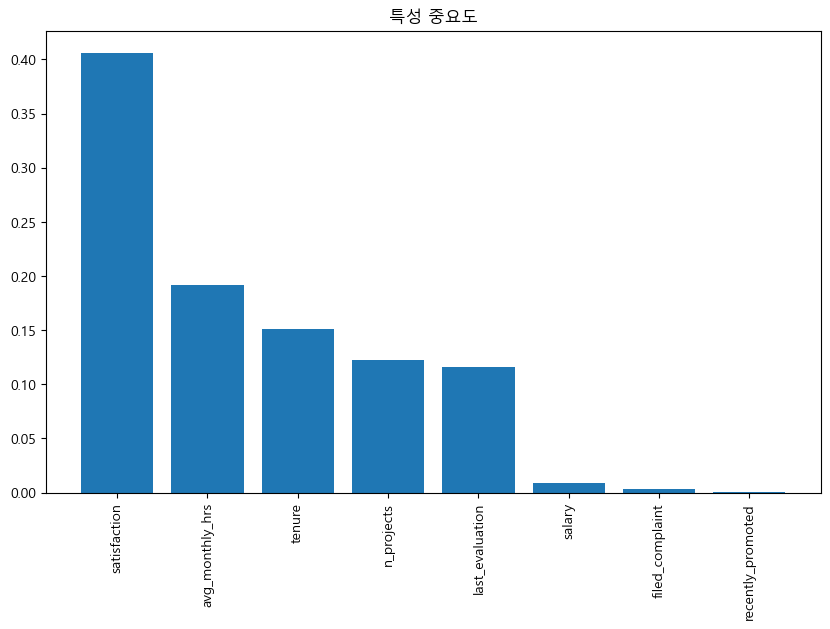

In [111]:
# Decision Tree 모델
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

decision_m = DecisionTreeClassifier()
decision_m.fit(X_train, y_train)
evaluate_model(decision_m, X_test, y_test, 'DecisionTreeClassifier 모델')

# 랜덤 포레스트 하이퍼파라미터 튜닝 (RandomizedSearchCV)
param_grid = {
    "max_depth": range(1, 6), 
    "max_leaf_nodes": range(3, 30),
    "max_features": np.arange(0.1, 1.1, 0.1)
}

# RandomizedSearchCV 활용
randomsearch = RandomizedSearchCV(estimator=decision_m, param_distributions=param_grid, n_iter=50, cv=3, n_jobs=-1, scoring='accuracy', random_state=0)
randomsearch.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 성능 출력
print("\n최적의 하이퍼파라미터 : ", randomsearch.best_params_,'\n')
dt_best = randomsearch.best_estimator_
best_params = randomsearch.best_params_

evaluate_model(dt_best, X_test, y_test, 'DecisionTree 최적 하이퍼파라미터')

# 최종 평가: 최적화된 모델을 평가하고 시각적으로 분석
evaluate_and_visualize_model(decision_m, X_test, y_test, 'DecisionTree 최적 하이퍼파라미터')

## 과적합 검증

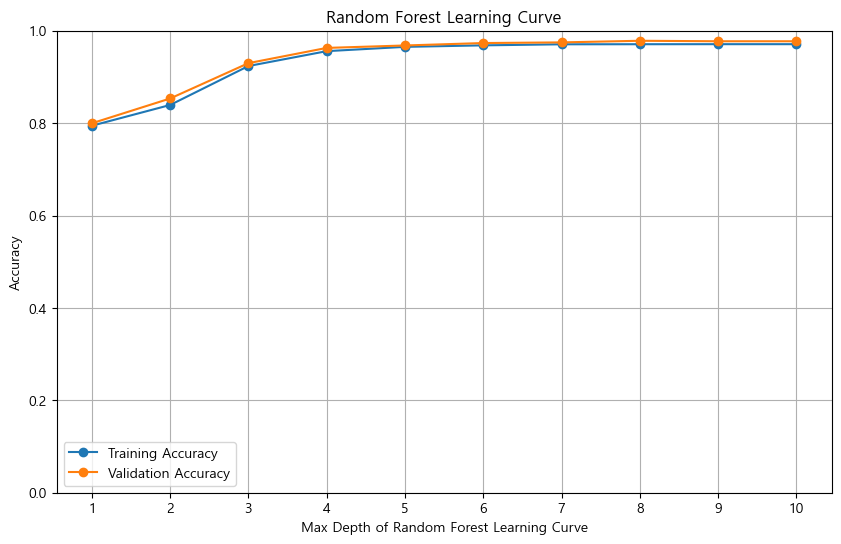

In [112]:
param_range = range(1, 11)  # 범위 설정

dt = DecisionTreeClassifier(random_state=0, max_depth=best_params['max_depth'], max_leaf_nodes=best_params['max_leaf_nodes'], max_features=best_params['max_features'])
plot_learning_curve_Decision(dt, X_train, y_train, X_test, y_test, param_range, title="DecisionTree Learning Curve")

============= XGBOOST 모델 모델 평가 지표 =============
Accuracy: 0.9817543859649123
Precision: 0.9720930232558139
Recall: 0.9485627836611196
F1 Score: 0.9601837672281777

최적의 하이퍼파라미터 :  {'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.7} 

============= XGBOOST 최적 하이퍼파라미터 모델 평가 지표 =============
Accuracy: 0.9828070175438597
Precision: 0.9841772151898734
Recall: 0.9409984871406959
F1 Score: 0.9621036349574633
혼동 행렬 : 


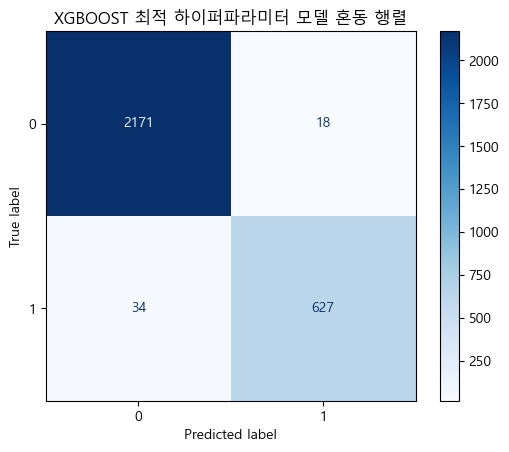

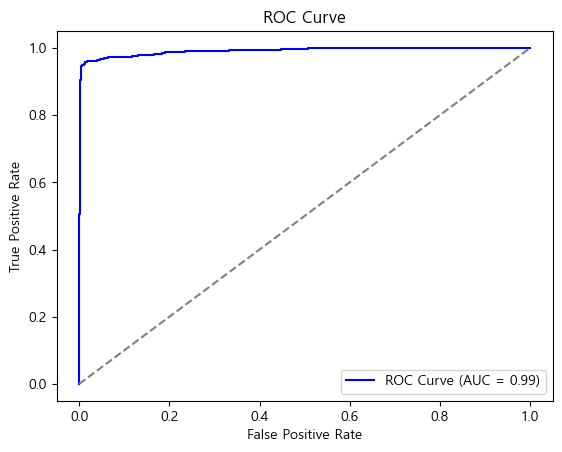

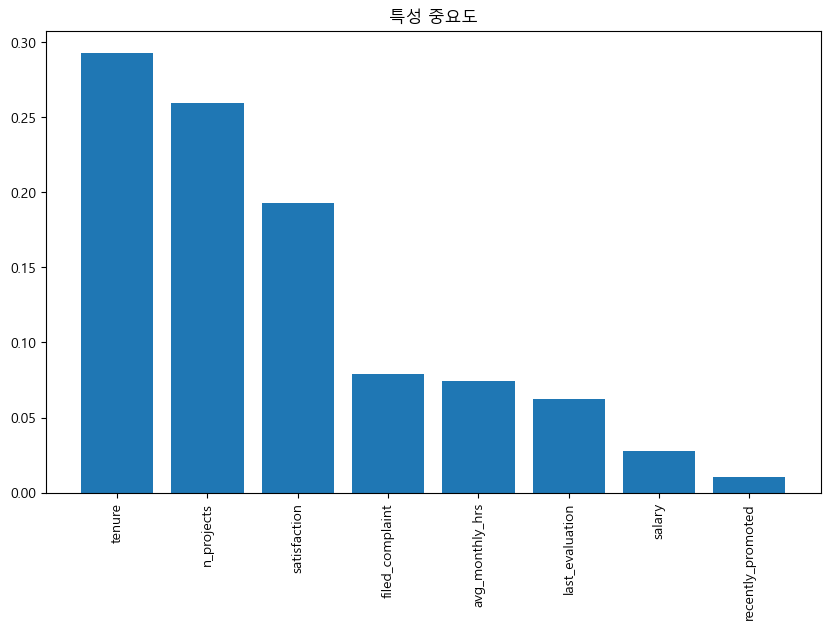

In [113]:
# XGBoost 모델
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_test, y_test, 'XGBOOST 모델')

# XGBOOST 하이퍼파라미터 튜닝 (RandomizedSearchCV)
params = {
    'learning_rate' : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
    'min_child_weight' : [ 1, 3, 5, 7 ],
    'gamma': [ 0.0, 0.1, 0.2, 0.3, 0.4 ],
    'colsample_bytree' : [ 0.3, 0.4, 0.5, 0.7 ]
}

# RandomizedSearchCV 활용
randomsearch = RandomizedSearchCV(estimator=xgb_model, param_distributions=params, n_iter=50, cv=3, n_jobs=-1, scoring='accuracy', random_state=0)
randomsearch.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 성능 출력
print("\n최적의 하이퍼파라미터 : ", randomsearch.best_params_,'\n')
xg_best = randomsearch.best_estimator_
best_params = randomsearch.best_params_
evaluate_model(xg_best, X_test, y_test, 'XGBOOST 최적 하이퍼파라미터')

# 최종 평가: 최적화된 모델을 평가하고 시각적으로 분석
evaluate_and_visualize_model(xgb_model, X_test, y_test, 'XGBOOST 최적 하이퍼파라미터')

In [114]:
import joblib

joblib.dump(xg_best, 'employee_churn_model.pkl')
print("Model saved as 'employee_churn_model.pkl'")

Model saved as 'employee_churn_model.pkl'


## 과적합 검증

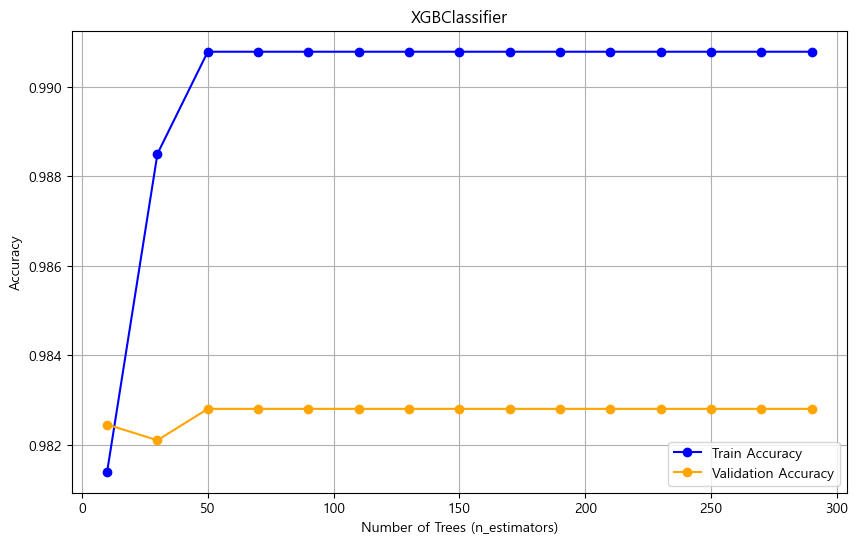

In [115]:
param_range = range(10, 300, 20)  # 범위 설정

# 모델 및 학습 곡선 시각화 호출
xg = XGBClassifier(random_state=0, min_child_weight=best_params['min_child_weight'], max_depth=best_params['max_depth'], learning_rate=best_params['learning_rate'], gamma=best_params['gamma'])
plot_learning_curve_ensemble(xg, X_train, y_train, X_test, y_test, param_range, title="XGBoost Learning Curve")

============= KNN 모델 모델 평가 지표 =============
Accuracy: 0.9617543859649123
Precision: 0.9011627906976745
Recall: 0.9379727685325264
F1 Score: 0.9191994069681245


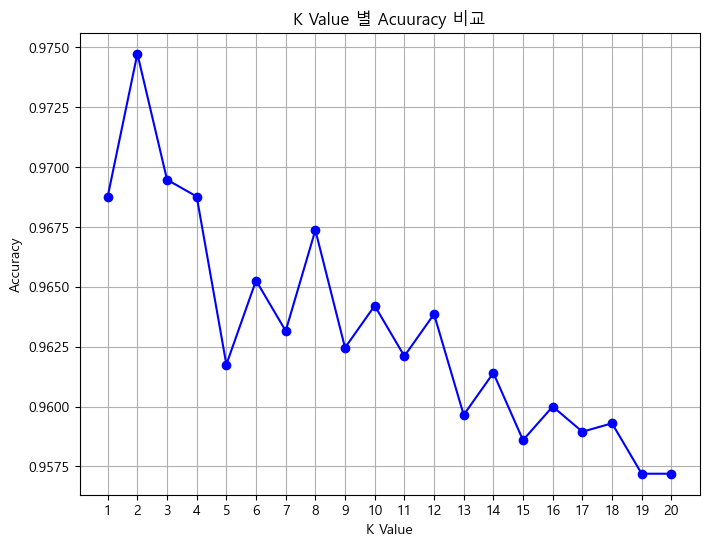


최적의 하이퍼파라미터 :  {'weights': 'distance', 'n_neighbors': 3, 'metric': 'minkowski', 'leaf_size': 30} 

============= KNN 최적 하이퍼파라미터 모델 평가 지표 =============
Accuracy: 0.9719298245614035
Precision: 0.9191919191919192
Recall: 0.9636913767019667
F1 Score: 0.9409158050221565
혼동 행렬 : 


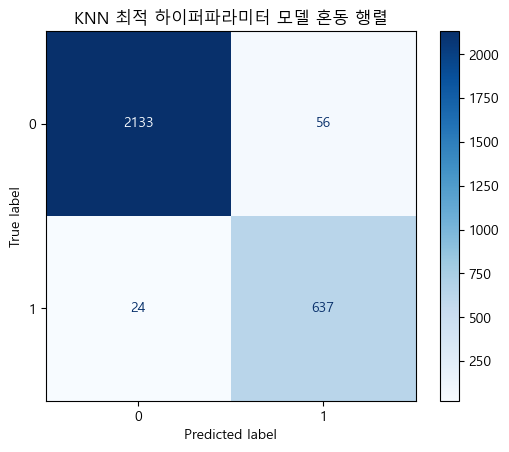

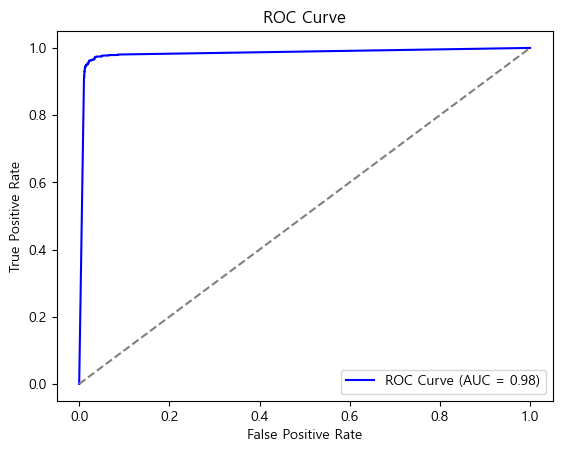

특성 중요도를 사용할 수 없는 모델입니다
Cross-Validation Accuracy: 0.9614003525707643 (+/- 0.003953587058123414)


In [116]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

# K-최근접 이웃 모델 생성
knn_model = KNeighborsClassifier(n_neighbors=5)  # K값 5로 설정
knn_model.fit(X_train, y_train)
evaluate_model(knn_model, X_test, y_test, 'KNN 모델')

# 모델의 k 값 변경하여 성능 비교
k_values = range(1, 21)  # k값 1부터 20까지 시험
accuracy_scores = []

# 각 k 값에 대해 성능을 측정
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# k 값에 따른 정확도 그래프
plt.figure(figsize=(8, 6))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-', color='b')
plt.title('K Value 별 Acuuracy 비교')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()


# 하이퍼파라미터 그리드 정의
param_dist = {
    'n_neighbors': range(3, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean'],
    'leaf_size': [20, 30]
}

# RandomizedSearchCV로 하이퍼파라미터 탐색
random_search = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 성능 출력
print("\n최적의 하이퍼파라미터 : ", random_search.best_params_,'\n')
knn_best = random_search.best_estimator_
best_params = random_search.best_params_

evaluate_model(knn_best, X_test, y_test, 'KNN 최적 하이퍼파라미터')

# 최종 평가: 최적화된 모델을 평가하고 시각적으로 분석
evaluate_and_visualize_model(knn_best, X_test, y_test, 'KNN 최적 하이퍼파라미터')

# 교차 검증 결과 출력
cv_scores = cross_val_score(knn_best, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean()} (+/- {cv_scores.std() * 2})")

## 과적합 검증

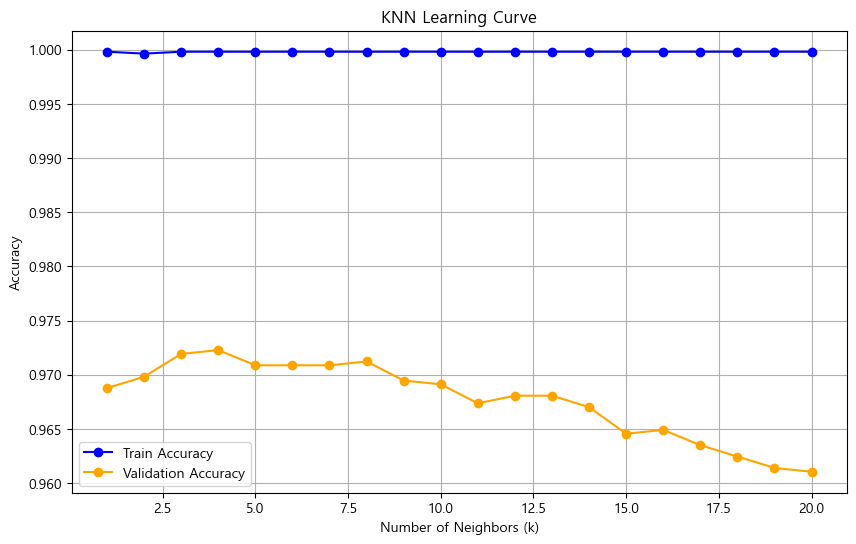

In [117]:
param_range = range(1, 21)  # 범위설정

knn = KNeighborsClassifier(weights=best_params['weights'], n_neighbors=best_params['n_neighbors'], metric=best_params['metric'], leaf_size=best_params['leaf_size'])
plot_learning_curve_KNN(knn, X_train, y_train, X_test, y_test, param_range, title="KNN Learning Curve")

# 딥러닝

In [118]:
# ! pip install tensorflow
# ! pip install pydot graphviz
# ! pip install pydot

Epoch 1/200


C:\Users\Playdata\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6997 - loss: 0.6406 - val_accuracy: 0.9112 - val_loss: 0.3591 - learning_rate: 0.0010
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8848 - loss: 0.3348 - val_accuracy: 0.9095 - val_loss: 0.2580 - learning_rate: 0.0010
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9149 - loss: 0.2571 - val_accuracy: 0.9439 - val_loss: 0.1919 - learning_rate: 0.0010
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9281 - loss: 0.2256 - val_accuracy: 0.9607 - val_loss: 0.1468 - learning_rate: 0.0010
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9356 - loss: 0.2060 - val_accuracy: 0.9653 - val_loss: 0.1251 - learning_rate: 0.0010
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9425 - loss: 0.1964 - val_accuracy: 0.9639 - val_loss: 0.1151 - learning_rate: 0.0010
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9442 - loss: 0.1890 - val_accuracy: 0.96

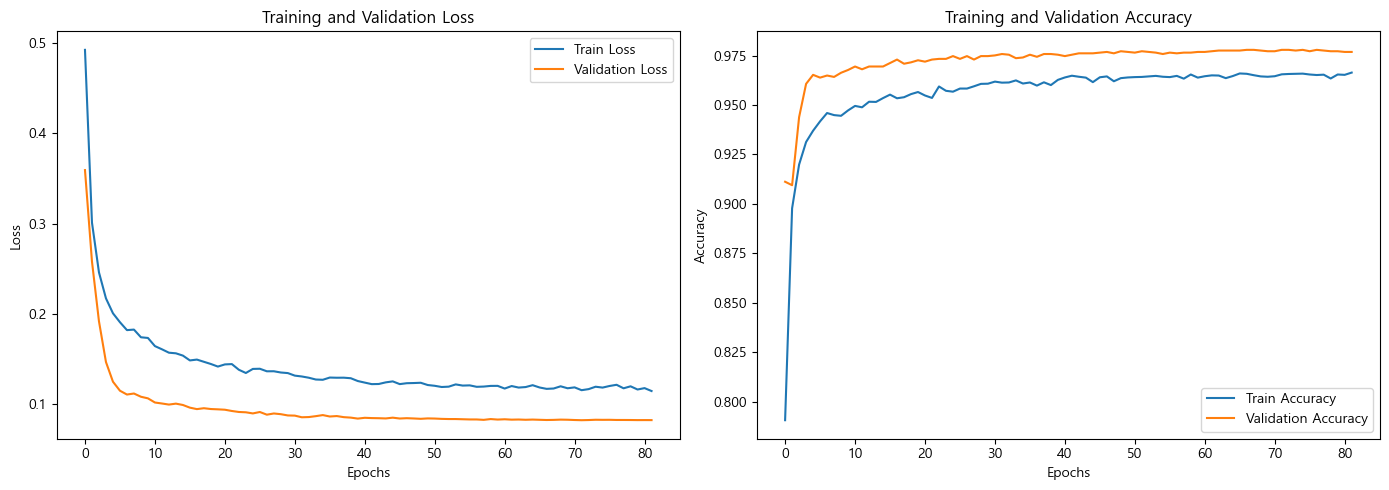

In [119]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras import mixed_precision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Mixed Precision 설정 (GPU 사용 시)
mixed_precision.set_global_policy('mixed_float16')

# 모델 정의
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 콜백 설정
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch > 10:
        return lr * 0.99
    return lr

lr_callback = LearningRateScheduler(lr_scheduler)

# 데이터셋 준비 (tf.data를 이용해 최적화)
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

# 모델 학습
history = model.fit(
    train_dataset,
    epochs=200,
    validation_data=val_dataset,
    callbacks=[reduce_lr, early_stopping, lr_callback]
)

# 모델 예측 및 성능 평가
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# 정확도, 정밀도, 재현율, F1 점수, ROC AUC 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict(X_test))

# 결과 출력
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# 학습 결과 시각화
# 1. 훈련 및 검증 손실 시각화
plt.figure(figsize=(14, 5))

# 훈련 및 검증 손실
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 2. 훈련 및 검증 정확도 시각화
# 훈련 및 검증 정확도
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()